# SARSA Algorithm for Taxi-v3 Environment

This notebook demonstrates the SARSA (State-Action-Reward-State-Action) algorithm, an on-policy temporal difference (TD) learning method, applied to the Taxi-v3 environment from Gymnasium.

In [1]:
# Install necessary libraries (if not already installed)
# !pip install gymnasium
# !pip install gymnasium[toy-text]
# !pip install matplotlib numpy

In [2]:
import gymnasium as gym
import numpy as np
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt

## 1. Environment Setup
We'll use the `Taxi-v3` environment. The agent's goal is to pick up a passenger from one location and drop them off at another.

In [3]:
# Create the Taxi-v3 environment
# render_mode="human" allows visualization, but for faster training, it's often set to None or not specified.
env = gym.make("Taxi-v3") # render_mode="human" for visualization during evaluation

# Display action space and observation space
print(f"Action Space: {env.action_space}")
print(f"State Space: {env.observation_space}")

# The state space is discrete with 500 states.
# The action space is discrete with 6 actions:
# 0: move south
# 1: move north
# 2: move east
# 3: move west
# 4: pickup passenger
# 5: dropoff passenger

Action Space: Discrete(6)
State Space: Discrete(500)


## 2. SARSA Algorithm Implementation

### Hyperparameters

In [4]:
alpha = 0.1  # Learning rate: how much new information overrides old information
gamma = 0.9  # Discount factor: importance of future rewards
epsilon = 0.1 # Exploration rate: probability of choosing a random action
EPOCHS = 40000 # Number of training episodes

### Q-table Initialization
The Q-table stores the expected future rewards for each state-action pair. It's initialized to zeros.

In [5]:
Q = np.zeros((env.observation_space.n, env.action_space.n))

### Action Selection (Epsilon-Greedy Strategy)
The agent chooses an action using an epsilon-greedy strategy. With probability `epsilon`, it explores by choosing a random action. Otherwise, it exploits its current knowledge by choosing the action with the highest Q-value for the current state.

In [6]:
def choose_action(state):
    """Chooses an action based on the epsilon-greedy strategy."""
    if random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()  # Explore: choose a random action
    else:
        action = np.argmax(Q[state, :])    # Exploit: choose the best known action
    return action

### SARSA Update Rule
The core of the SARSA algorithm. The Q-value for a state-action pair is updated based on the reward received, and the Q-value of the *next state and the next action actually taken*.

$Q(s, a) \leftarrow Q(s, a) + \alpha [r + \gamma Q(s', a') - Q(s, a)]$

In [7]:
def update_sarsa(state, action, reward, next_state, next_action):
    """Updates the Q-value for a state-action pair using the SARSA rule."""
    predict = Q[state, action]
    target = reward + gamma * Q[next_state, next_action] # SARSA uses Q(s', a')
    Q[state, action] = Q[state, action] + alpha * (target - predict)

### Training Loop

In [8]:
# For plotting metrics
all_epochs_steps = [] # Stores the number of steps taken in each episode
all_cumulative_rewards = [] # Stores the cumulative reward for each episode

print("Starting SARSA Training...")
for i in range(1, EPOCHS + 1):
    state, info = env.reset() # Reset environment to a new initial state
    action = choose_action(state) # Choose the first action (A)
    
    epochs_steps = 0 # Counter for steps in the current episode
    cumulative_reward = 0 # Accumulator for rewards in the current episode
    done = False
    truncated = False
    
    while not (done or truncated):
        # Execute the chosen action (A) and observe the outcome (S', R)
        next_state, reward, done, truncated, info = env.step(action)
        
        # Choose the next action (A') from the next state (S') using the policy
        next_action = choose_action(next_state)
        
        # Update the Q-table using SARSA rule: Q(S, A, R, S', A')
        update_sarsa(state, action, reward, next_state, next_action)
        
        # Move to the next state and action
        state = next_state
        action = next_action
        
        cumulative_reward += reward
        epochs_steps += 1
        
    # Store metrics for this episode
    all_epochs_steps.append(epochs_steps)
    all_cumulative_rewards.append(cumulative_reward)
    
    # Print progress (e.g., every 10000 episodes)
    if i % 10000 == 0:
        clear_output(wait=True) # Clears the output to show fresh status
        print(f"Episode: {i}/{EPOCHS}")
        # Optional: Print average steps/rewards for the last N episodes for better insight
        if i >= 100:
             print(f"  Avg steps (last 100): {np.mean(all_epochs_steps[-100:])}")
             print(f"  Avg reward (last 100): {np.mean(all_cumulative_rewards[-100:])}")

clear_output(wait=True)
print("SARSA Training finished.\n")

SARSA Training finished.



## 3. Visualizing Training Performance

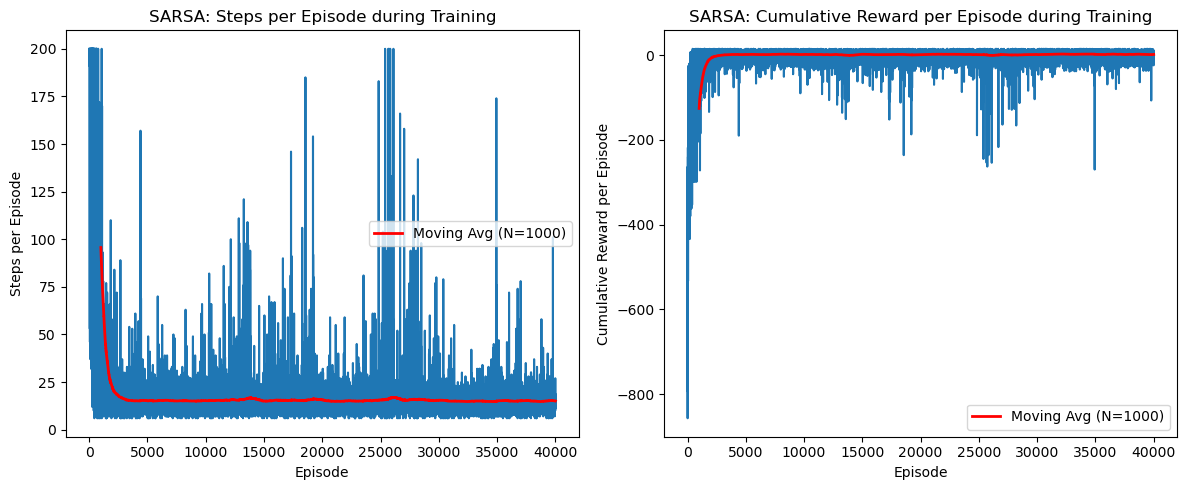

In [9]:
# Plotting steps per episode
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(all_epochs_steps)
plt.xlabel("Episode")
plt.ylabel("Steps per Episode")
plt.title("SARSA: Steps per Episode during Training")

# Optional: Plot a moving average for steps to see the trend more clearly
N = 1000 # Window size for moving average
moving_avg_steps = np.convolve(all_epochs_steps, np.ones(N)/N, mode='valid')
plt.plot(np.arange(N-1, len(all_epochs_steps)), moving_avg_steps, color='red', linewidth=2, label=f'Moving Avg (N={N})')
plt.legend()

# Plotting cumulative rewards per episode
plt.subplot(1, 2, 2)
plt.plot(all_cumulative_rewards)
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward per Episode")
plt.title("SARSA: Cumulative Reward per Episode during Training")

# Optional: Plot a moving average for rewards
moving_avg_rewards = np.convolve(all_cumulative_rewards, np.ones(N)/N, mode='valid')
plt.plot(np.arange(N-1, len(all_cumulative_rewards)), moving_avg_rewards, color='red', linewidth=2, label=f'Moving Avg (N={N})')
plt.legend()

plt.tight_layout()
plt.show()

## 4. Evaluating the Trained Agent
After training, we evaluate the agent's performance by running it in the environment using the learned Q-table (exploitation only, no exploration).

In [11]:
total_epochs_eval, total_penalties_eval = 0, 0
num_eval_episodes = 100 # Number of episodes to run for evaluation

print(f"\nStarting Evaluation for {num_eval_episodes} episodes...")
env_eval =  gym.make("Taxi-v3", render_mode="human")

for _ in range(num_eval_episodes):
    state, info = env_eval.reset()
    epochs, penalties, reward_eval = 0, 0, 0
    done, truncated = False, False
    
    while not (done or truncated):
        # During evaluation, always choose the best action (exploit)
        action = np.argmax(Q[state]) 
        state, reward_eval, done, truncated, info = env_eval.step(action)
        
        if reward_eval == -10: # Standard penalty for illegal actions in Taxi-v3
            penalties += 1
        
        epochs += 1

    total_penalties_eval += penalties
    total_epochs_eval += epochs

env_eval.close()

print("Evaluation Finished.")
print(f"Average timesteps per episode: {total_epochs_eval / num_eval_episodes}")
print(f"Average penalties per episode: {total_penalties_eval / num_eval_episodes}")


Starting Evaluation for 100 episodes...


: 

## 5. Visualizing an Episode (Optional)
To see the agent in action, you can render one episode.

In [ ]:
print("\nVisualizing one episode with the trained SARSA agent...")
env_render = gym.make("Taxi-v3", render_mode="human")
state, info = env_render.reset()
done, truncated = False, False
total_reward_render = 0
steps_render = 0

while not (done or truncated):
    env_render.render() # Render the current state
    action = np.argmax(Q[state]) # Choose best action
    state, reward, done, truncated, info = env_render.step(action)
    total_reward_render += reward
    steps_render += 1
    # Optional: Add a small delay to make visualization easier to follow
    # import time
    # time.sleep(0.1)

env_render.render() # Render the final state
print(f"Episode finished after {steps_render} steps.")
print(f"Total reward for the episode: {total_reward_render}")
env_render.close()

## 6. Displaying the Learned Q-table (Partial)
The Q-table can be very large. Here's a look at a small part of it.

In [ ]:
print("\nLearned Q-table (first 5 states):")
print(Q[:5])